# Module imports


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from datetime import datetime

# Functions


In [2]:
def prepend_date(filename):
    today = pd.Timestamp.today().strftime('%Y-%m-%d')
    return today + '_' + filename

# TASKS:
0.  set hostspeciesTaxID to integer
2. How to trim string entries to <92 characters?
3. How to look up data from csv/excel file and merge them into dataframe? (for Header file and PHI-species file)
4. How to report data for certain years or releases? Can you visually display that and how?





# Code

## Load data file and format columns

In [3]:
#Read complete data sets:  phiSlim: the complete data set with 30 columns
url = 'https://raw.githubusercontent.com/martin2urban/phi4statsPy/main/phiSlim30cols.csv'
column_names= ['PhiAcc', 'ProtId', 'PathSpecies', 'PathSpeciesTaxID', 'Phenotype', 'Literature_Id', 'Year_published', 'HostSpeciesTaxId', 'DiseaseName']
my_types = {
    "PhiAcc": "string",
    "ProtId": "string",
    "PathSpecies": "string",
    "PathSpeciesTaxID": "string",
    "Phenotype": "string",
    "Literature_Id": "string",
    "Year_published": "string",
    "HostSpeciesTaxId": "string",
    "DiseaseName": "string",    #does not convert yet from object to string
}

phiSlim = pd.read_csv(
    url,
    usecols=column_names,
    dtype=my_types,
    header=0,
    skiprows=[1],
)
phiSlim['Year_published'] = pd.to_datetime(phiSlim['Year_published'], format='%Y')    #conver year_published to datetime, function from numpy
phiSlim['PathSpeciesTaxID'] = phiSlim['PathSpeciesTaxID'].astype(str).str.strip()
phiSlim['PathSpeciesTaxID'] = pd.to_numeric(phiSlim['PathSpeciesTaxID'], errors='coerce', downcast='integer') #to numeric replace non-convertible
phiSlim['Literature_Id'] = phiSlim['Literature_Id'].astype(str).str.strip()
phiSlim['Literature_Id'] = pd.to_numeric(phiSlim['Literature_Id'], errors='coerce', downcast='integer') #to numeric replace non-convertible with NaN
phiSlim['Literature_Id'] = phiSlim['Literature_Id'].fillna(0).astype(int) #replace NaN with 0, to allow int 32 data type
phiSlim['Phenotype'] = phiSlim['Phenotype'].astype('category')
phiSlim.info()
#phiSlim.to_csv(('phiSlim.csv'), index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21674 entries, 0 to 21673
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   PhiAcc            21674 non-null  string        
 1   ProtId            21674 non-null  string        
 2   PathSpeciesTaxID  21674 non-null  int32         
 3   PathSpecies       21674 non-null  string        
 4   DiseaseName       21375 non-null  string        
 5   HostSpeciesTaxId  21674 non-null  string        
 6   Phenotype         21674 non-null  category      
 7   Literature_Id     21674 non-null  int32         
 8   Year_published    21354 non-null  datetime64[ns]
dtypes: category(1), datetime64[ns](1), int32(2), string(5)
memory usage: 1.2 MB


# Make stats-counts reports and save to files

In [4]:
#  Make global stats counts for phiSlim
column_names = ['PhiAcc', 'PathSpecies', 'ProtId', 'HostSpeciesTaxId', 'Literature_Id', 'DiseaseName']
aggregations = {'PhiAcc': 'count', 'PathSpecies': 'nunique', 'ProtId': 'nunique', 'HostSpeciesTaxId': 'nunique', 'Literature_Id': 'nunique', 'DiseaseName': 'nunique'}
global_data = phiSlim[column_names].agg(aggregations).reset_index()
global_data    #needs write statement

,index,0
0,PhiAcc,21674
1,PathSpecies,293
2,ProtId,9664
3,HostSpeciesTaxId,243
4,Literature_Id,5298
5,DiseaseName,546


In [5]:
from IPython.core.interactiveshell import InteractiveShell     #dipslay all outputs from this cell
InteractiveShell.ast_node_interactivity = 'all'               #dipslay all outputs from this cell

# make stats-counts report
# 1==================================================================
# tabulate tally: species x genes x interactions
# Group by 'PathSpecies' and calculate distinct 'PhiAcc' count and count of rows
data = phiSlim.groupby('PathSpecies').agg({'PhiAcc': 'nunique', 'PathSpecies': 'size'}).rename(columns={'PhiAcc': 'genes', 'PathSpecies': 'PHI.base.accession'}).reset_index()
# Sort the DataFrame by 'PHI.base.accession' in descending order
data = data.sort_values('PHI.base.accession', ascending=False)
data = data.rename(columns={'PHI.base.accession': 'interactions'})  # Rename 'PHI.base.accession' column to 'interactions'
data.reset_index(drop=True) # Reset index and drop the old index column
data.to_csv(prepend_date('phiSlim_speciesBYpathogen_geneBYinteraction_tally.csv'), index=False)   #write dataframe to csv
# 2==================================================================
# Report number of species per genus
# Split data "species name
data2 = data['PathSpecies'].str.split(' ', expand=True).rename(columns={0: 'genus', 1: 'species'})
data2 = data2.iloc[:, [0, 1]]
# Group by genus and count distinct species
data3 = data2.groupby('genus').agg(Species=('species', 'nunique')).reset_index()
# Sort by descending species count
data3 = data3.sort_values('Species', ascending=False)
data3.reset_index(drop=True)  #drop = True drops the current index and resets the index to start at 0
# Write to CSV
#data3.to_csv(pd.Timestamp.today().strftime('%Y-%m-%d') +'_phiSlim_genus_no_Species.csv', index=False)

,genus,Species
0,fusarium,12
1,colletotrichum,11
2,streptococcus,10
3,pseudomonas,9
4,xanthomonas,9
...,...,...
147,helicobacter,1
148,grosmannia,1
149,glaesserella,1
150,gaeumannomyces,1


In [6]:
#This code groups the phi DataFrame by the 'PathSpecies' column, counts the occurrences of each 'PathSpecies' value using size(), and then sorts the result in descending order using sort_values().
tally = phiSlim.groupby('PathSpecies').size().reset_index(name='n')
# Tally all pathogens and  interactions and save csv file: phi_tally_all_pathog&interact,csv
tally.rename(columns={'PathSpecies': 'Tally-All-PathSpecies'}, inplace=True)
tally.index = tally.index + 1
tally
tally.to_csv(prepend_date('phi_tally_all_pathog&interact.csv'))
# Tally the top30 pathogens
top30 = tally.sort_values(by='n', ascending=False).head(30).reset_index(drop=True)
top30.rename(columns={'Tally-All-PathSpecies': 'Top30-PathSpecies'}, inplace=True)
top30.index = top30.index + 1
top30

,Tally-All-PathSpecies,n
1,acinetobacter baumannii,294
2,acinetobacter nosocomialis,36
3,actinobacillus pleuropneumoniae,33
4,aeromonas hydrophila,16
5,aeromonas salmonicida,5
...,...,...
289,yersinia enterocolitica,16
290,yersinia pestis,90
291,yersinia pseudotuberculosis,49
292,yersinia ruckeri,3


,Top30-PathSpecies,n
1,fusarium graminearum,1811
2,magnaporthe oryzae,1602
3,salmonella enterica,1214
4,ralstonia solanacearum,935
5,candida albicans,760
6,pseudomonas aeruginosa,739
7,staphylococcus aureus,656
8,escherichia coli,641
9,xanthomonas oryzae,626
10,erwinia amylovora,549


## Graphical data display

Text(0.5, 0, 'Year_published')

Text(0, 0.5, 'Number of Unique Literature_Ids')

Text(0, 0.5, 'Cumulative Sum of Literature_Ids')

Text(0.5, 1.0, 'Number of Unique Literature_Ids and Cumulative Sum Over Year_published')

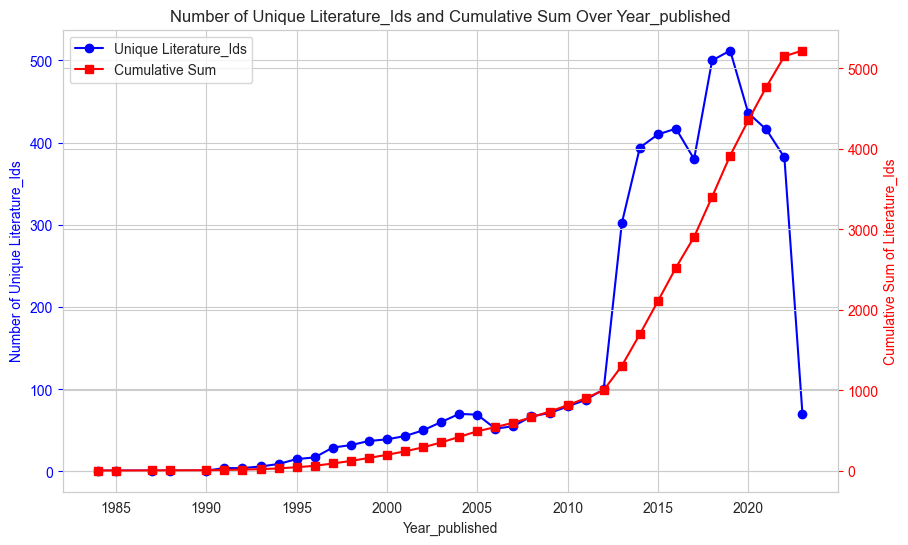

In [7]:
import matplotlib.pyplot as plt
# Group by 'Year_published' and count unique 'Literature_Id'
unique_literature_counts = phiSlim.groupby('Year_published')['Literature_Id'].nunique()
# Calculate the cumulative sum of unique 'Literature_Id'
cumulative_sum = unique_literature_counts.cumsum()
# Plotting the line graph with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))
# Plot the number of unique Literature_Ids on the first y-axis
ax1.plot(unique_literature_counts.index, unique_literature_counts, marker='o', color='b', label='Unique Literature_Ids')
ax1.set_xlabel('Year_published')
ax1.set_ylabel('Number of Unique Literature_Ids', color='b')
ax1.tick_params('y', colors='b')
ax1.grid(True)
# Create a second y-axis for the cumulative sum
ax2 = ax1.twinx()
ax2.plot(cumulative_sum.index, cumulative_sum, marker='s', color='r', label='Cumulative Sum')
ax2.set_ylabel('Cumulative Sum of Literature_Ids', color='r')
ax2.tick_params('y', colors='r')
# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Number of Unique Literature_Ids and Cumulative Sum Over Year_published')
plt.show()


In [8]:
#STOP


In [9]:
# Snippets beneath this point